# JDPLS Student Modeling Lecture

### Demo Notebook (Solution)

Inspired by content from EPFL's [Machine Learning for Behavioral Data](https://github.com/epfl-ml4ed/mlbd-2023) course.  
**Teaching Team**: Prof. Tanja Käser, Vinitra Swamy   
**Date**: March 6th, 2024   


**Overview**: In this tutorial, we introduce a Bayesian Knowledge Tracing (BKT) model to represent students' acquiry of knowledge through problem solving. This model is used in many intelligent tutoring systems (ITS) as a way to estimate what skills students have mastered and what skills they need improvement on. 

We will train the BKT model from scratch and examine the behavior of students across different skills through their BKT learning curves. To do this, we will use data from a popular, real-world learning platform called ASSISTments.

**Dataset**: ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. The dataset involves 4,217 middle-school students practicing an electronic tutor that teaches and evaluates students in grade-school math, with a total of 525,534 trials. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

We first load the data set.

In [24]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model

In [25]:
assistments = pd.read_csv('assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [26]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


To keep things simpler for demonstration purposes, we will focus on the following 6 skills in this lecture:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [27]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Mode', 'Circle Graph', 'Area Rectangle', 'Division Fractions', 'Finding Percents', 'Venn Diagram'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


## BKT Model - Training & Prediction

We will use a train-test setting (20% of students in the test set). The `create_iterator` function creates an iterator object able to split student's interactions included in data in 10 folds such that the same student does not appear in two different folds. To do so, we appropriately initialize a scikit-learn's GroupShuffleSplit iterator with 80% training set size and non-overlapping groups, then return the iterator.

In [28]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator. 

In [29]:
tested_user_ids = set()
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # There should only be one iteration per skill, because we only specify one fold for the split. 
        # If we wanted multiple folds, we could expand the n_splits parameter in create_iterator.
        user_ids = skill_data['user_id'].unique()
        train_user_ids = skill_data.iloc[train_index]['user_id'].unique()
        test_user_ids = skill_data.iloc[test_index]['user_id'].unique()
        print('Iteration:', iteration)
        print('Intersection between train and test user IDs:', set(train_user_ids) & set(test_user_ids))
        print('All user IDs in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
        print('User IDs tested more than once:', set(tested_user_ids) & set(test_user_ids))
        print('')

-- Circle Graph --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs tested more than once: set()

-- Venn Diagram --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs tested more than once: set()

-- Mode --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs tested more than once: set()

-- Division Fractions --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs tested more than once: set()

-- Finding Percents --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs tested more than once: set()

-- Area Rectangle --
Iteration: 0
Intersection between train and test user IDs: set()
All user IDs in train and test user union: True
User IDs 

In our split, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.  

Next, we train a BKT model for each skill on the training data set and then predict on the test data set.
We obtain `df_preds`, a data frame containing the predictions for each user and skill in the test data set. We output the overall RMSE and AUC scores.

In [30]:
rmse_bkt, auc_bkt = [], []
df_preds = pd.DataFrame()
# Train a BKT model for each skill
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # Split data in training and test sets
        X_train, X_test = skill_data.iloc[train_index], skill_data.iloc[test_index]
        # Initialize and fit the model
        model = Model(seed=0)
        %time model.fit(data=X_train) 
        # Compute predictions
        preds = model.predict(data=X_test)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
        df_preds = pd.concat([df_preds, preds])
        
# Print the the resulting dataframe
display(df_preds)

-- Circle Graph --
CPU times: user 4.23 s, sys: 10.5 ms, total: 4.24 s
Wall time: 2.03 s
-- Venn Diagram --
CPU times: user 6.51 s, sys: 13 ms, total: 6.52 s
Wall time: 3.29 s
-- Mode --
CPU times: user 2.85 s, sys: 7.83 ms, total: 2.86 s
Wall time: 1.48 s
-- Division Fractions --
CPU times: user 3.87 s, sys: 2.07 ms, total: 3.87 s
Wall time: 1.97 s
-- Finding Percents --
CPU times: user 4.97 s, sys: 9.95 ms, total: 4.98 s
Wall time: 2.48 s
-- Area Rectangle --
CPU times: user 2.23 s, sys: 0 ns, total: 2.23 s
Wall time: 1.09 s


,user_id,skill_name,correct,correct_predictions
3969,64525,Circle Graph,1,0.46504
3970,64525,Circle Graph,1,0.63973
3971,64525,Circle Graph,1,0.69360
3972,64525,Circle Graph,0,0.70475
3973,64525,Circle Graph,1,0.70026
...,...,...,...,...
337153,96264,Area Rectangle,1,0.89255
337154,96264,Area Rectangle,1,0.97978
337159,96270,Area Rectangle,1,0.89255
337167,96292,Area Rectangle,1,0.89255


In [31]:
# Compute overall RMSE and AUC
rmse = mean_squared_error(df_preds.correct, df_preds.correct_predictions, squared = False)
AUC = roc_auc_score(df_preds.correct, df_preds.correct_predictions)
print('Overall RMSE:', np.round(rmse, 3), 'Overall AUC:', np.round(AUC, 3))

Overall RMSE: 0.356 Overall AUC: 0.866


We hypothesize that performance of the model could depend on the skill. Some skills might be more difficult to predict than others. Next, we therefore compute the RMSE and AUC separately for each skill.

In [32]:
# We first compute the metrics for the specific skill "Circle Graph"
skill_1 = 'Circle Graph'

filtered_preds = df_preds[df_preds['skill_name'] == skill_1]

# Compute RMSE and AUC
rmse = mean_squared_error(filtered_preds.correct, filtered_preds.correct_predictions, squared = False)
auc = roc_auc_score(filtered_preds.correct, filtered_preds.correct_predictions)

results = {'skill': skill_1, 'rmse': np.round(rmse, 3), 'auc': np.round(auc, 3)}

print(results)

{'skill': 'Circle Graph', 'rmse': 0.454, 'auc': 0.734}


In [33]:
# Compute RMSE and AUC per skill (for all skills)
skill_rmse = df_preds.groupby(['skill_name']).apply(lambda df_preds: mean_squared_error(df_preds.correct, df_preds.correct_predictions, squared=False))
print('RMSE: ', np.round(np.mean(skill_rmse),3), '(mean)', np.round(np.std(skill_rmse), 3), '(std)')

skill_auc = df_preds.groupby(['skill_name']).apply(lambda df_preds: roc_auc_score(df_preds.correct, df_preds.correct_predictions))
print('AUC: ', np.round(np.mean(skill_auc), 3), '(mean)', np.round(np.std(skill_auc), 3), '(std)')

RMSE:  0.375 (mean) 0.072 (std)
AUC:  0.789 (mean) 0.058 (std)


Next, we visualize our results in a bar chart. We display the overall RMSE and AUC (over all skills) including standard deviations as well as the per skill performance metrics.

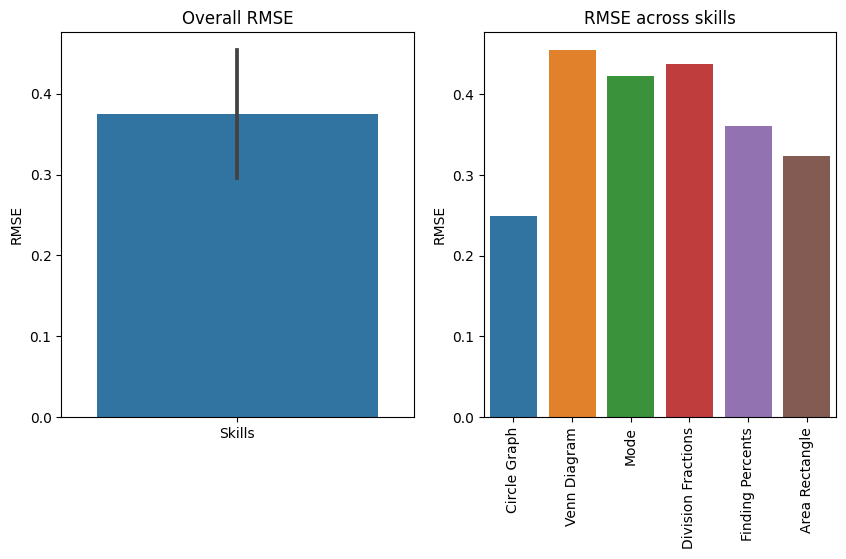

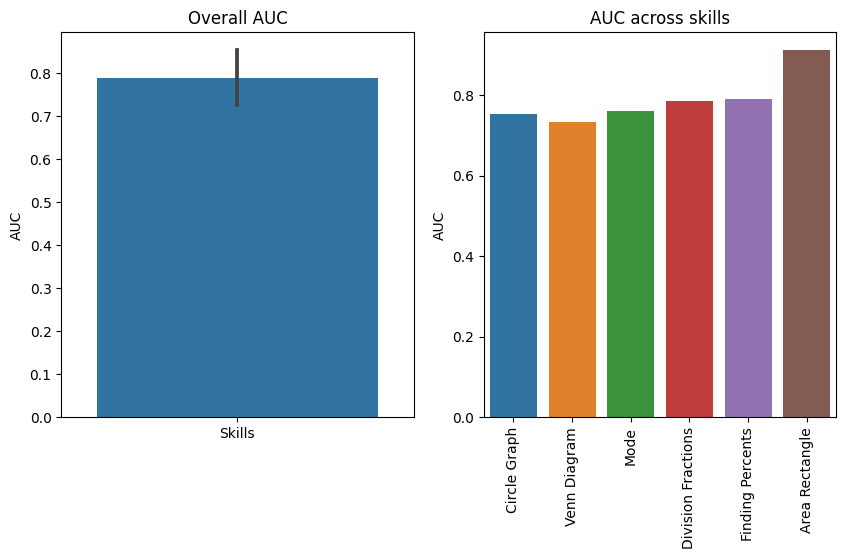

In [34]:
# Create overall RMSE and RMSE per skill data frames
skills_all = ['Skills']*len(skills_subset)
df_overall_rmse = pd.DataFrame(list(zip(skills_all, skill_rmse)),
               columns =['x', 'RMSE'])
df_skill_rmse = pd.DataFrame(list(zip(skills_subset, skill_rmse)),
               columns =['x', 'RMSE'])

# Create overall AUC and AUC per skill data frames
df_overall_auc = pd.DataFrame(list(zip(skills_all, skill_auc)),
               columns =['x', 'AUC'])
df_skill_auc = pd.DataFrame(list(zip(skills_subset, skill_auc)),
               columns =['x', 'AUC'])

# Two bar plots for RMSE: first one with std (mean RMSE over all skills), then one bar plot with a bar for each specific skill
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(ax=axes[0],x='x', y='RMSE', data=df_overall_rmse, estimator=np.mean, errorbar='sd')
axes[0].set_title('Overall RMSE')
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],x='x', y='RMSE', data=df_skill_rmse, estimator=np.mean, errorbar='sd')
plt.xticks(rotation=90)
axes[1].set_title('RMSE across skills')
axes[1].set_xlabel('')

fig.show()

# Two bar plots for AUC: first one with std (mean AUC over all skills), then one bar plot with a bar for each specific skill
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(ax=axes[0],x='x', y='AUC', data=df_overall_auc, estimator=np.mean, errorbar='sd')
axes[0].set_title('Overall AUC')
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],x='x', y='AUC', data=df_skill_auc, estimator=np.mean, errorbar='sd')
plt.xticks(rotation=90)
axes[1].set_title('AUC across skills')
axes[1].set_xlabel('')

fig.show()

Examining the RMSE across skills, we note that Venn Diagram has the largest RMSE, closely followed by division fractions and mode. The Circle Graph skills has the least RMSE (around 0.25) and is therefore most accurate. There is a large standard deviation across the average RMSE (top left plot), which indicates that the RMSE scores for BKT are skill-dependent.

We observe that the AUC is relatively high, on average ~78% across skills. Area Rectangle has a very high AUC while the other skills remain between the 75% to 80% range. The lack of variation between skills shows some indication that AUC is not as skill-dependent as RMSE (but this can only be confirmed by looking at a larger number of skills).

## BKT Model - Learning Curves

We now know how to train a BKT model to predict the probability that a student will solve a task correctly. Congrats! We can also use this type of model to compute learning curves to analyze students' learning activity (in our case using the ASSISTment skills).

We will compute learning curves for the following six skills:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

We first fit a BKT model with all default parameters, i.e., Model(seed=0) in pyBKT, on the full data data set (no split into train and test set needed as we are not assessing predictive performance of the model here, but just checking interpretation). 

In [35]:
# Initialize the model
model = Model(seed=0)

# Fit the model on the entire dataset
%time model.fit(data=data)

predictions = model.predict(data=data)[['user_id', 'skill_name', 'correct', 'correct_predictions']]

# Rename the dataframe columns as per instructions
predictions.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']

CPU times: user 27.7 s, sys: 86.6 ms, total: 27.8 s
Wall time: 13.9 s


In [36]:
predictions.head()

,user_id,skill_name,y_true,y_pred_bkt
3957,14,Circle Graph,0,0.45809
3958,14,Circle Graph,1,0.33157
3959,14,Circle Graph,0,0.56919
3960,14,Circle Graph,0,0.44552
3961,14,Circle Graph,0,0.32156


Next, we create a function that computes the learning curve (observed or predicted) for us by averaging over the success rate of all users at a given opportunity.

In [37]:
def avg_y_by_x(x, y):
    '''
    Compute average learning curve and number of students over the number of opportunities. 
    x is the number of opportunities.
    y the success rates of the users (can be predicted success rate or true success rate).
    '''
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

Then, we create a function for plotting learning curve and a bar chart with the number of students per opportunity for a given skill.

In [38]:
def plot_learning_curve(skill_name):
    '''
    Plot learning curve using BKT model for skill `skill_name`. 
    '''
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_bkt columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_bkt columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_bkt columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    plt.show()

Finally, we display and interpret the learning curves for the six selected skills.

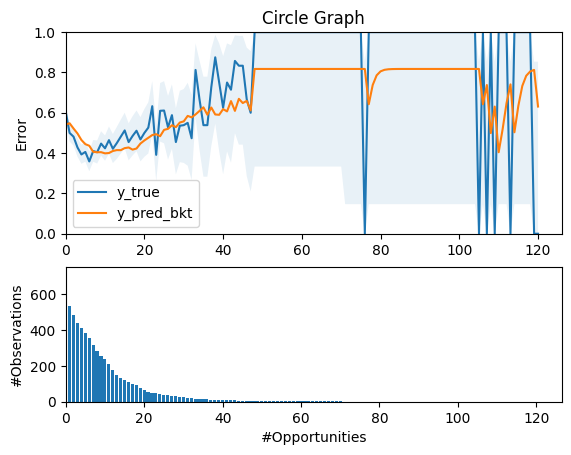

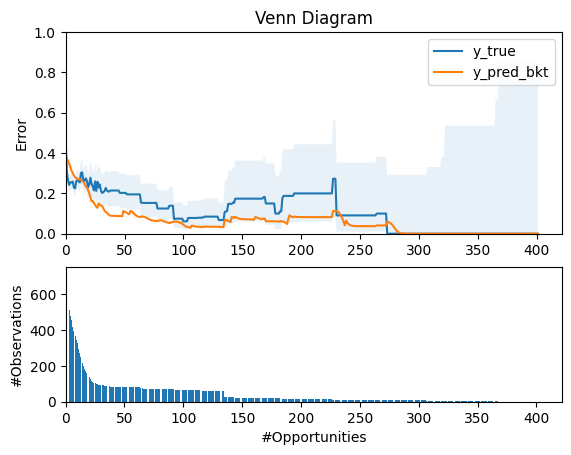

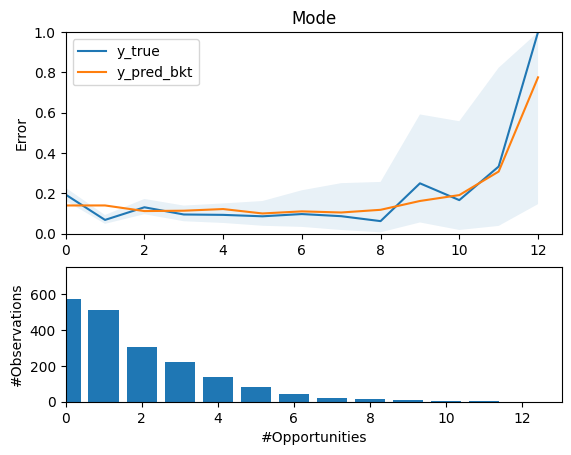

In [39]:
for skill_name in skills_subset[:3]: # For the first three skills under consideration
    plot_learning_curve(skill_name)

We first discuss the first three skills separately. Then, given that we are showing the same aspects for the six skills, we provide few more observations aimed at comparing the findings we obtained across the skills under consideration. 

- "**Circle Graph**". From the error rate in the ground-truth data (y_true, blue), it can be observed that this skill appears quite hard for students, with an initial error rate of around 0.60 in the first opportunity. The error rate goes slightly down, as we would usually expect, as much as the students play with the skill, reaching the lowest error rate of 0.38 at around 7 opportunities. However, starting from #opportunities around equal to 7, the error rate starts going up till 0.80 after 50 opportunities. It seems that a large part of the students managed to master a bit this skill in the first opportunities, but then they start facing difficulties in mastering it. This behavior might be due to the fact that the skill is ill-defined or that the problems become too difficult or are not aligned well with the skill.  After 50 opportunities, the error rate starts jumping between 0 and a 1 just because there are only few students. In terms of confidence interval (blue area), it can be observed that the error rate is quite stable at the earlier stage. Starting from around 7 opportunities, the error rate is less stable probably due to the same reasons we provided above. The confidence interval finally becomes large when only few students keep playing with this skill for a higher number of opportunities. When it comes to consider the error rate obtained by the BKT model estimations (y_pred_bkt, orange), it can be observed that the model tends to overestimate a bit the error rate during the first opportunities (the orange line is above the blue one, the model tends to predict more errors than expected), while the opposite pattern is observed for higher numbers of opportunities (the model tends to predict less errors than expected). However, in general, the model fits well the ground-truth data. Looking at the bar plot at the bottom, students appear reasonably engaged with this skill only for few opportunities (particularly, starting from 35 opportunities, the number of involved students is low, and the error rate starts jumping more).            


- "**Venn Diagram**". This third skill appears like another somehow easy skill since the beginning (y_true, blue), but a bit more harder than "Mode". Except for a few fluctuations in the very first opportunities (where the curve slightly increases, maybe because they are just the first opportunities or due to the type/difficulty of problems proposed at that point), the error rate goes down till around 0.08, reached at around 100 opportunities. Probably, once only those students struggling more with this skill tend to stay for a higher number of opportunities, the error rate goes up again. The confidence interval for the ground-truth data (blue area) is relatively high (if compared with the one observed for the other two skills during the first opportunities). Naturally, it increases even more when the number of students reaching that number of opportunities is very low (#opportunities > 130). Comparing the ground-truth estimations with the BKT estimations (y_pred_bkt, orange), except for the first opportunities, it can be observed that BKT tends to consistently underestimate the error rate and the BKT error rate is often outside the confidence interval of actual data. The number of students per opportunity naturally goes down as observed for the other skills, but interestingly it can be observed that a set of students seems to still keep playing with this skill from around 30 opportunites till 100 opportunities stably (the bar plot values appear somehow similar in that range).  


- "**Mode**". Based on the patterns of the ground-truth data (y_true, blue), the error rate observed for this skill at the earlier stages is of around 0.20. The students thus are already good in problems involving this skill, somehow. While this might depend on the intrinsic knowledge/background of the students about this skill, this behavior might also appear due to the fact that the skill is easier and easier to master in general or that the problems presented to the students on that skill are too easy, for instance. While the error rate goes slightly down when the number of opportunities increases, the difference between the initial error rate and the error rate experienced (for instance) after 5 or 6 opportunities is relatively small (around 0.10 of error rate in the latter case). This observation might be justified by the fact that students played with the skill only for few opportunities (so there is no so much room for improving more) and by the already low initial error rate (students might use those opportunities just to refine their knowledge, with few errors still happening). The going-up behavior at the end appears mainly due to the very low number of students involved at that point. The blue area shows us that the confidence interval is very small for the first three or four opportunities (so behavior is more consistent among students), while it starts increasing later probably also due to the peculiar patterns behind students who interact more with this skill. The BKT model (y_pred_bkt, orange) is able to fit the ground-truth data very well across the number of opportunities, especially till around 8 opportunities. One important observation comes from the bar plot, which shows that the number of students involved in this skill drastically goes down especially after three/four opportunities. 


Overall, comparing the first three skills, "Circle Graph" seems to be really going up (e.g., ill-defined skill or due to the type/difficulty of problems), while, for "Mode" and "Venn Diagram", the going up later seems to come only from the very low number of students. Especially but not only for the "Venn Diagram" skill, the BKT generally tends to under-estimate the error rate. One reason behind this observation could be that the BKT model we adopted did not consider forgetting, for instance. In terms of number of opportunities, students experienced a lower maximum number of opportunities on the "Mode" skill, compared to the others. Compared to "Circle Graph", the skill "Venn Diagram" seems to involve lots of students even for higher number of opportunities (e.g., #opportunities > 30). 

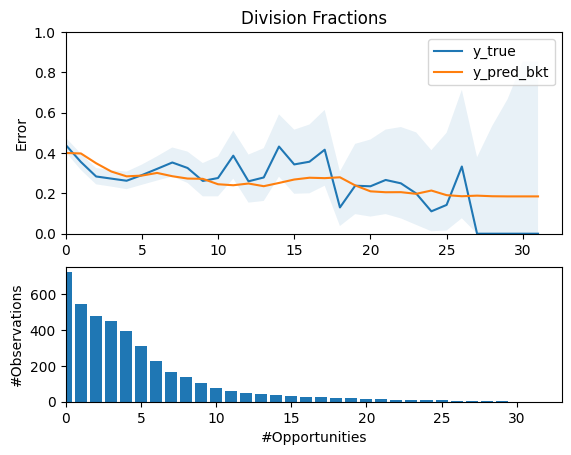

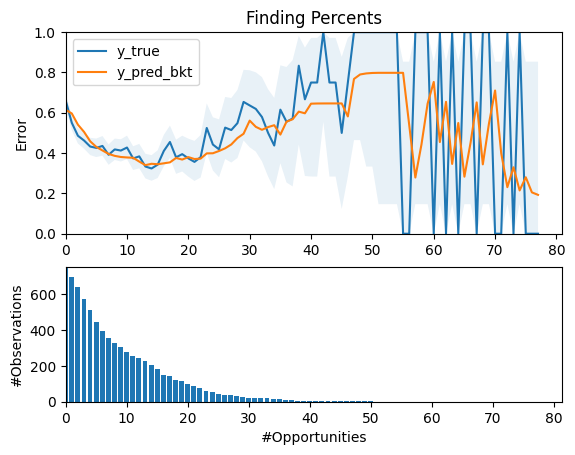

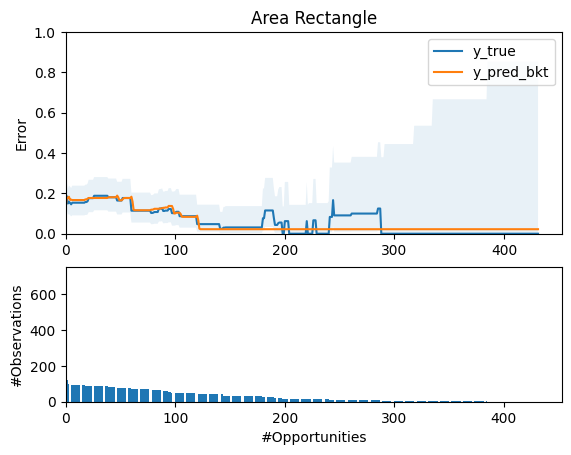

In [40]:
for skill_name in skills_subset[3:]: # For the remaining three skills under consideration    
    plot_learning_curve(skill_name)

We briefly discuss the remaining three learning curves. 

- "**Division Fractions**". With a 40% error rate in the ground truth curve (y_true, blue), we can see that this skill is generally moderately difficult for students (not very easy, but the majority of the students correctly solve the problem on the first attempt). The error rate decreases slightly with no major jumps as the number of opportunities increases, which means that 1) the problems in the skill are close to equally difficult and 2) more opportunities leads to students improving on the problem (lower error rate). The y_pred_bkt learning curve (orange) for this skill is close to straight and slightly downward trending from 40% to 20%, which shows that students improve on the problem the more attempts that are made. However, the BKT model fails to capture the 0% error rate at 30 opportunities, likely due to the few number of data points around 25/30 observations.


- "**Finding Percents**". We identify that this skill is difficult for the majority of students because 60% of students do not pass this problem on the first try. We see a downwards curve in error rate in the ground truth and BKT predictions from 0 to 20 opportunities, where the error drops from 60% to 40%. However, after that, we see a steading increase until 50 opportunties, which shows that if a student has over 20 opportunities in this skill, they are not likely to pass it even until 50 opportunities -- more opportunities does not help. We note very odd behavior of the learning curves between 50 and 80, which can be directly attributed to a small number of observational data points (examining the bottom bar plot).


- "**Area Rectangle**". Students find the problems in this skill very easy to solve, with an initial error rate of 20% across both the ground truth and the BKT predictive curves, and steadily dropping overall. One interesting trend is between 0 to 60 opportunities, we do not see a notable decrease in error rate, which leads us to say that up to the 50 first opportunities do not make a significant difference in average student's aptitude on the skill. Between 60 and 100, we see a notable drop to an error rate of 10% and then another step, where the difference between 60 and 100 opportunities does not change the error rate. Around 125 opportunities, the error rate flatlines to a very small percentage, showing that most students have mastered the skill. This step-wise learning curve could be indicative of a quirk in the curriculum, and we would recommend further analysis of the problem distribution to understand why this appears. It is notable that the prediction learning curve (orange) fails to capture the peaks in student learning rate between 175 and 300, likely due to the low numbers of opportunities.


Examining all 6 skills, we see that Circle Graphs and Finding Percents have similar behavior as difficult problems, Venn Diagram and Area Rectangle have similar behavior as easier problems, and the remaining two skills have unique patterns.